## 什么是epsilon-greedy policy
- 上次代码说到MCES效果并不好，因为即使随机获取start state来生成多条episodes，但仍然有一些state并未探索到。
- 这是由于policy都是由一堆0和一个1组成，即每个state选择执行时都会选择最优的action，是确定的路径。
- epsilon-greedy policy，在执行这个时，state大概率选最优的，但也有小概率会选择其他的actions。 这种policy也被称为soft polices，能够加强MC-Exploring-Start的探索能力，这样所有state都可能在episodes中被探索到。

In [35]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

class GridWorld:
    def __init__(self, rows=7, cols=7, goal=(5,5), reward= -1, forbidden=[(1,4),(2,3),(2,2),(3,3),(4,5)]):
        self.rows = rows
        self.cols = cols
        self.goal = goal
        self.reward = reward
        self.forbidden = set(forbidden)
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1),   # left
            4: (0, 0)    # stay
        }

        self.left_map = {0:3, 1:0, 2:1, 3:2, 4:4}   # 左转90°
        self.right_map = {0:1, 1:2, 2:3, 3:0, 4:4}  # 右转90°
    
    def get_goal(self):
        return self.goal

    def step(self, state, action):
        """输入 state=(r,c), action，返回 (next_state, reward)"""
        r, c = state

        # 随机转移
        if action == 4:
            dr, dc = self.actions[action]
        else:
            prob = np.random.rand()
            if prob < 0.1:   # 左偏
                action = self.left_map[action]
            elif prob < 0.2: # 右偏
                action = self.right_map[action]
            # 其余 80% 保持不变
            dr, dc = self.actions[action]

        new_r, new_c = r + dr, c + dc

        # 撞墙
        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            return state, -5 + self.reward

        # 禁区
        if (new_r, new_c) in self.forbidden:
            return (new_r, new_c), -10 + self.reward

        # 到达目标
        if (new_r, new_c) == self.goal:
            return (new_r, new_c), 10 + self.reward

        # 普通移动
        return (new_r, new_c), 0 + self.reward
    
    def get_states(self):
        """返回所有可用状态"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                states.append((r, c))
        return states
    
    
    def render(self, policy=None, values=None, cell_size=1.2):
        """可视化：白色=正常, 黄=禁区, 蓝=goal，cell_size=每格大小"""
        fig, ax = plt.subplots(figsize=(self.cols * cell_size, self.rows * cell_size))
        
        grid = np.ones((self.rows, self.cols, 3))  # 默认白色
        for (r, c) in self.forbidden:
            grid[r, c] = [1, 1, 0]  # 黄色
        gr, gc = self.goal
        grid[gr, gc] = [0, 0, 1]  # 蓝色

        # 关键：加上 origin="upper"，确保坐标和数组一致
        ax.imshow(grid, origin="upper")

        # 如果有值函数
        if values is not None:
            for (r, c), v in values.items():
                ax.text(c, r + 0.25, f"{v:.1f}", 
                        ha='center', va='top', color='black', fontsize=12)

        # 如果有策略
        if policy is not None:
            arrows = {0: "↑", 1: "→", 2: "↓", 3: "←", 4: "O"}
            for (r, c), a in policy.items():
                ax.text(c, r - 0.2, arrows[a], ha='center', va='center',color='red', fontsize=16, fontweight='bold')

        # 设置网格
        ax.set_xticks(np.arange(-0.5, self.cols, 1))
        ax.set_yticks(np.arange(-0.5, self.rows, 1))
        ax.grid(which="both", color="black", linewidth=1)

        # 去掉刻度
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

In [36]:
def epsilon_greedy(Q, state, actions, eps=0.1):
    """epsilon-greedy策略"""
    best_action = max(actions.keys(), key=lambda a: Q[(state, a)])  
    if np.random.rand() < eps:
        return np.random.choice(list(actions.keys()))  # 随机探索
    else:
        return best_action  # 利用

In [37]:
def MC_epsilon_Greedy(env, max_iterations=1000, gamma=0.9, T=100):
    """蒙特卡洛epsilon-Greedy算法"""
    states = env.get_states() # 所有状态
    state_action_pairs = [(s, a) for s in states for a in env.actions.keys()] # 所有的state-action对

    Q = {(s, a): 0 for s, a in state_action_pairs}  # 初始化储存所有state-action pair的Q值
    policy = {s:0 for s in states}# 初始化策略
    value = {s:0 for s in states} # 初始化状态值函数
    pairs_count = {(s, a): 0 for s, a in state_action_pairs}  # 初始化每个state-action对的访问次数

    for episode in range(max_iterations):
        state, action = state_action_pairs[np.random.randint(len(state_action_pairs))] # 随机选择一个state-action对作为起点

        # 生成一个episode
        episode_states = []
        episode_actions = []
        episode_rewards = []

        for t in range(T):
            if t > 0:  # 从第二步开始用 epsilon-greedy
                action = epsilon_greedy(Q, state, env.actions, eps=0.1)  # 根据epsilon-greedy策略选择下一个动作
            next_state, reward = env.step(state, action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state  # 更新state
            if state == env.get_goal:  # 如果到达终点，提前结束
                break
        
        # 从后往前：计算回报G，并更新Q值，并更新策略(注意，range的起始值包括在内，终止值不包括在内)
        G = 0 # state的回报
        for t in range(len(episode_states)-1, -1, -1):
            # 获得当前的state, action, reward
            state_t = episode_states[t]
            action_t = episode_actions[t]
            reward_t = episode_rewards[t]

            #右边是上一个state的回报，左边是当前state的回报
            G = reward_t + gamma * G
            
            # 更新该state-action对的访问次数
            pairs_count[(state_t, action_t)] += 1

            # 更新Q值 / policy evaluation
            Q_old = Q[(state_t, action_t)] # 旧的Q值
            Q_new = Q_old + (G - Q_old) / pairs_count[(state_t, action_t)] # 增量式更新Q值
            Q[(state_t, action_t)] = Q_new

        # Policy Improvement
        # 更新策略
        for state in states:
            for action in env.actions.keys():
                best_action = policy[state]
                if Q[(state, action)] > Q[(state, best_action)]:
                    policy[state] = action
        
    # 计算最终的状态值函数
    for s in states:
        value[s] = Q[(s, policy[s])]

    return policy, value, max_iterations

所有状态： [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
状态数： 49
Value Iteration converged in 1000 iterations.


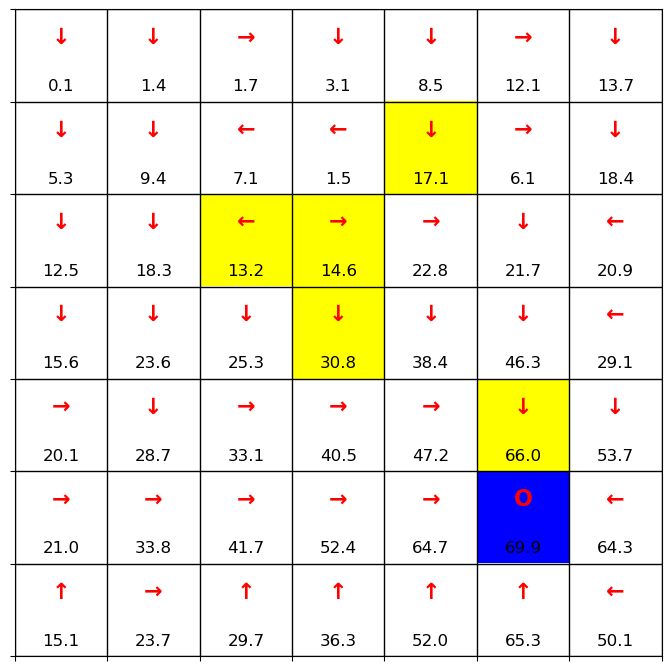

In [38]:
# 运行
env = GridWorld()

states = env.get_states()
print("所有状态：", states)
print("状态数：", len(states))

policy, values, iterations = MC_epsilon_Greedy(env)
print(f"Value Iteration converged in {iterations} iterations.")
env.render(policy, values)